## Cargar datos y definir features/target

In [3]:
import pandas as pd
import numpy as np

# Cargar el dataset de equipos
df = pd.read_csv("pokemon_teams_100k.csv")

# Ver columnas para confirmar
print(df.columns)

# Definimos las columnas numéricas que usaremos como entrada (features)
feature_cols = [
    "sum_hp",
    "sum_attack",
    "sum_defense",
    "sum_sp_attack",
    "sum_sp_defense",
    "sum_speed",
    "mean_hp",
    "mean_attack",
    "mean_defense",
    "mean_sp_attack",
    "mean_sp_defense",
    "mean_speed",
]

target_col = "strong_team"

X = df[feature_cols].values
y = df[target_col].values

print("Shape X:", X.shape)
print("Shape y:", y.shape)
print("Proporción de clases:", np.mean(y))


Index(['p1_name', 'p2_name', 'p3_name', 'p4_name', 'p5_name', 'p6_name',
       'sum_hp', 'sum_attack', 'sum_defense', 'sum_sp_attack',
       'sum_sp_defense', 'sum_speed', 'mean_hp', 'mean_attack', 'mean_defense',
       'mean_sp_attack', 'mean_sp_defense', 'mean_speed', 'team_power_score',
       'strong_team'],
      dtype='object')
Shape X: (100000, 12)
Shape y: (100000,)
Proporción de clases: 0.5


## Train / Validation / Test split

In [4]:
from sklearn.model_selection import train_test_split

# Primero separamos test (15%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

# Luego, de train_val sacamos validation (del 85% restante, 15/85 ≈ 0.176)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.176, random_state=42, stratify=y_train_val
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Train: (70040, 12) Val: (14960, 12) Test: (15000, 12)


## Estandarizar features

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


## Función auxiliar para evaluar modelos clásicos

In [6]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

def evaluar_modelo(nombre, modelo, X_tr, y_tr, X_te, y_te):
    modelo.fit(X_tr, y_tr)
    y_pred = modelo.predict(X_te)
    
    acc = accuracy_score(y_te, y_pred)
    f1 = f1_score(y_te, y_pred)
    
    print(f"\n=== {nombre} ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("Reporte de clasificación:")
    print(classification_report(y_te, y_pred, digits=4))
    
    return acc, f1


## Modelo 1: Regresión Logística (baseline)

In [7]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000, random_state=42)
acc_log, f1_log = evaluar_modelo(
    "Regresión Logística",
    log_reg,
    X_train_scaled,
    y_train,
    X_test_scaled,
    y_test
)



=== Regresión Logística ===
Accuracy: 0.9087
F1-score: 0.9086
Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.9079    0.9097    0.9088      7500
           1     0.9096    0.9077    0.9086      7500

    accuracy                         0.9087     15000
   macro avg     0.9087    0.9087    0.9087     15000
weighted avg     0.9087    0.9087    0.9087     15000



## Modelo 2: Random Forest

In [8]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

acc_rf, f1_rf = evaluar_modelo(
    "Random Forest",
    rf,
    X_train,   # RF no necesita features escaladas
    y_train,
    X_test,
    y_test
)



=== Random Forest ===
Accuracy: 0.9058
F1-score: 0.9057
Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.9049    0.9069    0.9059      7500
           1     0.9067    0.9047    0.9057      7500

    accuracy                         0.9058     15000
   macro avg     0.9058    0.9058    0.9058     15000
weighted avg     0.9058    0.9058    0.9058     15000



## Modelo 3: SVM

In [9]:
from sklearn.svm import SVC

svm_rbf = SVC(
    kernel="rbf",
    C=1.0,
    gamma="scale",
    random_state=42
)

acc_svm, f1_svm = evaluar_modelo(
    "SVM RBF",
    svm_rbf,
    X_train_scaled,
    y_train,
    X_test_scaled,
    y_test
)



=== SVM RBF ===
Accuracy: 0.9080
F1-score: 0.9080
Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.9082    0.9077    0.9080      7500
           1     0.9078    0.9083    0.9080      7500

    accuracy                         0.9080     15000
   macro avg     0.9080    0.9080    0.9080     15000
weighted avg     0.9080    0.9080    0.9080     15000



## Modelo 4: Red neuronal (MLP en Keras)

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models

input_dim = X_train_scaled.shape[1]

model = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(64, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(1, activation="sigmoid")  # salida binaria
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,945 (11.50 KB)

 Trainable params: 2,945 (11.50 KB)

 Non-trainable params: 0 (0.00 B)

### Entrenar la red

In [11]:
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=20,
    batch_size=256,
    verbose=1
)


Epoch 1/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8827 - loss: 0.2646 - val_accuracy: 0.9070 - val_loss: 0.2120
Epoch 2/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9113 - loss: 0.1981 - val_accuracy: 0.9070 - val_loss: 0.2079
Epoch 3/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9114 - loss: 0.1978 - val_accuracy: 0.9069 - val_loss: 0.2085
Epoch 4/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9116 - loss: 0.1972 - val_accuracy: 0.9070 - val_loss: 0.2066
Epoch 5/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9118 - loss: 0.1969 - val_accuracy: 0.9075 - val_loss: 0.2065
Epoch 6/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9120 - loss: 0.1964 - val_accuracy: 0.9079 - val_loss: 0.2063
Epoch 7/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9114 - loss: 0.1963 - val_accuracy: 0.9075 - val_loss: 0.2063
Epoch 8/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9120 - loss: 0.1960 - val_accuracy: 0.

### Evaluación en test

In [12]:
# Predicciones en test
y_proba = model.predict(X_test_scaled).ravel()
y_pred_nn = (y_proba >= 0.5).astype(int)

acc_nn = accuracy_score(y_test, y_pred_nn)
f1_nn = f1_score(y_test, y_pred_nn)

print("\n=== Red Neuronal (Keras MLP) ===")
print(f"Accuracy: {acc_nn:.4f}")
print(f"F1-score: {f1_nn:.4f}")
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred_nn, digits=4))


469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step

=== Red Neuronal (Keras MLP) ===
Accuracy: 0.9083
F1-score: 0.9074
Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.9006    0.9180    0.9092      7500
           1     0.9164    0.8987    0.9074      7500

    accuracy                         0.9083     15000
   macro avg     0.9085    0.9083    0.9083     15000
weighted avg     0.9085    0.9083    0.9083     15000



## Comparar todos los modelos

In [13]:
resultados = pd.DataFrame({
    "Modelo": [
        "Regresión Logística",
        "Random Forest",
        "SVM RBF",
        "Keras MLP"
    ],
    "Accuracy": [acc_log, acc_rf, acc_svm, acc_nn],
    "F1-score": [f1_log, f1_rf, f1_svm, f1_nn]
})

print(resultados)


                Modelo  Accuracy  F1-score
0  Regresión Logística  0.908733  0.908642
1        Random Forest  0.905800  0.905693
2              SVM RBF  0.908000  0.908025
3            Keras MLP  0.908333  0.907439


## Matriz de Confusión

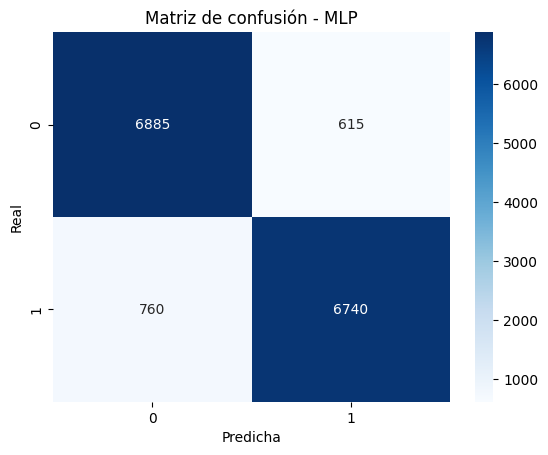

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_nn)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicha")
plt.ylabel("Real")
plt.title("Matriz de confusión - MLP")
plt.show()


## Distribución del team_power_score

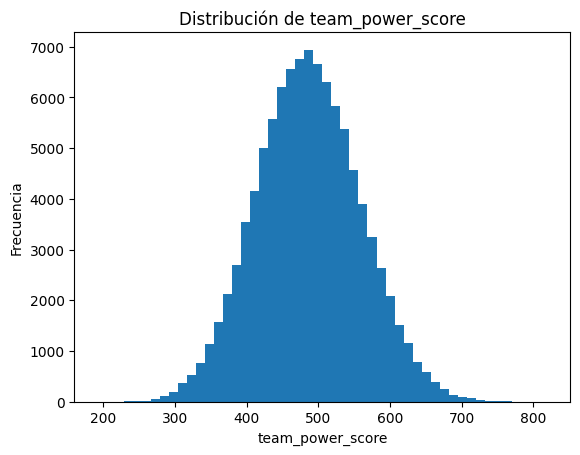

In [16]:
import matplotlib.pyplot as plt

plt.hist(df["team_power_score"], bins=50)
plt.title("Distribución de team_power_score")
plt.xlabel("team_power_score")
plt.ylabel("Frecuencia")
plt.show()


## Balance de Strong_team

In [17]:
df["strong_team"].value_counts(normalize=True)


strong_team
1    0.5
0    0.5
Name: proportion, dtype: float64

## Correlación de features

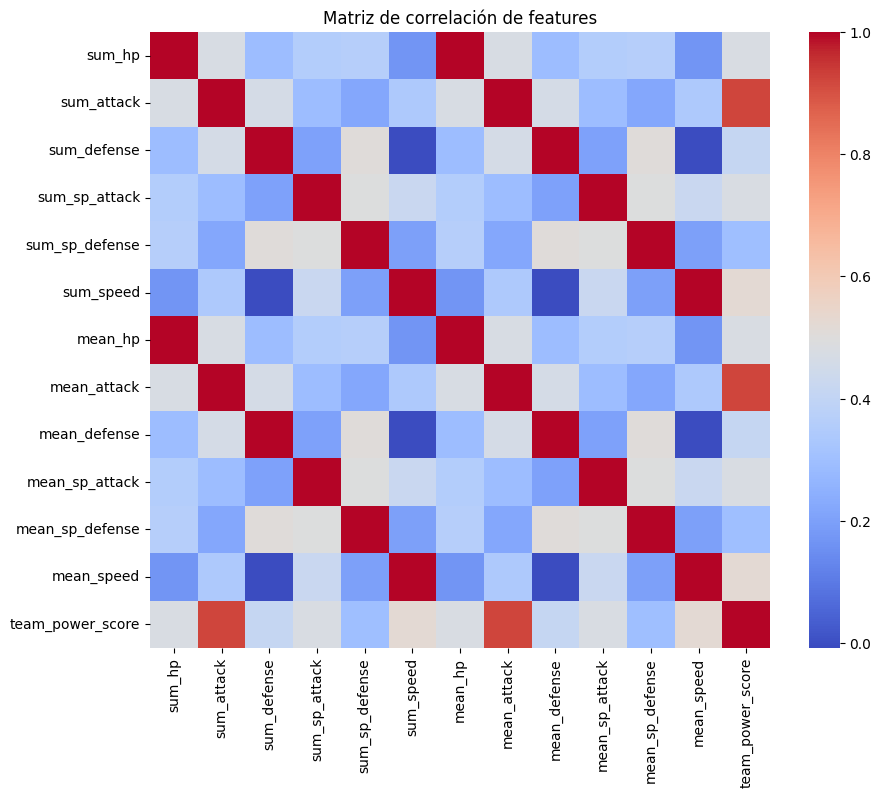

In [18]:
import seaborn as sns

corr = df[feature_cols + ["team_power_score"]].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title("Matriz de correlación de features")
plt.show()
